## Part 1 Build Dataset

In [1]:
import tools1
import tools
import pickle
import numpy as np

def make_sorted_list_and_save(days):
    pickle_in = open("stock_price_dict.pickle","rb")
    price_dict_ = pickle.load(pickle_in)
    #DATA_DIR = 'D:\Dataset\EarningsCallData\ReleasedDataset\ReleasedDataset_mp3'
    DATA_DIR = '.\EarningsCallData\ACL19_Release\ACL19_Release'
    stock_volatility_3days, text_all, date, company = tools1.calculate_volatility(price_dict_, days, DATA_DIR)
    combined_list = list(zip(date, stock_volatility_3days, company, text_all))
    print(len(combined_list))
    sorted_list1 = sorted(combined_list, key=lambda x: x[0])#按照列表中元素的第一个索引（日期）进行排序

    np.save(f'sorted_volatility_{days}days.npy', sorted_list1)

    stock_movement_3days, text_all, date, company = tools.calculate_movement(price_dict_, days, DATA_DIR)
    combined_list = list(zip(date, stock_movement_3days, company, text_all)) #进行数据的聚合、组合或并行处理。
    print(len(combined_list))
    sorted_list2 = sorted(combined_list, key=lambda x: x[0])#按照列表中元素的第一个索引（日期）进行排序

    np.save(f'sorted_movement_{days}days.npy', sorted_list2)

def make_and_save(days):
    make_sorted_list_and_save(days)

if __name__ == "__main__":
    print()
    make_and_save(3)

  5%|▍         | 26/572 [00:00<00:06, 85.29it/s]

Error Company: Aetna IncDate: 2017-01-31
Error Company: Aetna IncDate: 2017-05-02
Error Company: Aetna IncDate: 2017-10-31


 19%|█▉        | 108/572 [00:01<00:04, 98.43it/s]

Error Company: CA, Inc.Date: 2017-08-02


 97%|█████████▋| 556/572 [00:05<00:00, 98.36it/s] 

Error Company: Vulcan MaterialsDate: 2017-08-02


100%|██████████| 572/572 [00:06<00:00, 94.04it/s]


5.129329438755057
563


 15%|█▌        | 87/572 [00:00<00:00, 862.34it/s]

Error Company: Aetna IncDate: 2017-01-31
Error Company: Aetna IncDate: 2017-05-02
Error Company: Aetna IncDate: 2017-10-31
Error Company: CA, Inc.Date: 2017-08-02


100%|██████████| 572/572 [00:00<00:00, 669.92it/s]


Error Company: Vulcan MaterialsDate: 2017-08-02
24.237429941531154
563


## Part 2 Token-Level Encoder

In [2]:
import transformers
from tqdm import tqdm #用于在循环迭代中显示进度条的库
import torch

#Generate sentence representation 使用预训练的语言模型来计算文本的嵌入表示
def emb_str(text):
    input_ids = torch.tensor([tokenizer.encode(text)])[:,:512] #使用 tokenizer 对文本进行编码，将其转换为输入张量 input_ids。编码后的张量可能会被裁剪为最大长度512。
    # print(input_ids.shape)
    with torch.no_grad(): #是一个上下文管理器，用于在执行期间禁用梯度计算。在这个上下文中，所有的张量操作都不会被跟踪，也不会导致梯度被计算和存储。这在进行推断或评估时非常有用，因为在这些情况下通常不需要计算梯度。
        last_hidden_states = model(input_ids)[0]  # Models outputs are now tuples 使用模型对输入张量进行前向传递，获得最后一层隐藏状态 只取第一个元素
        emb = last_hidden_states.cpu().numpy() #将最后一层隐藏状态转移到 CPU 上，并将其转换为 NumPy 数组
    return emb

# Padding
def make(days,name):
    list = np.load(f"sorted_{name}_{days}days.npy")
    embs = []
    labels = []
    sentence_len = []
    for i in tqdm(range(len(list))):
        # print(list[i])
        text = (list[i][2] + "\n" + list[i][3]).split("\n")#company \n text contnent
        sentence_len.append(len(text))
        text_embs = emb_str(text)
        text_embs = np.squeeze(text_embs)#将 text_embs 中的单维度条目进行删除，以便在后续的处理中更方便地使用
        # text_embs = np.concatenate((text_embs, np.array([np.array(past_volatility_all[i])] * len(text_embs))), axis=1)
        embs.append(text_embs)
        labels.append(float(list[i][1]))#movement value->labels

    b = np.zeros([len(embs),len(max(embs,key = lambda x: len(x))),1024])#创建一个全零数组 b，形状为 (len(embs), max_sentence_len, 1024)，用于存储嵌入向量，并将嵌入向量复制到 b 中对应的位置
    for i,j in enumerate(embs):#使用 enumerate(embs) 遍历嵌入向量列表 embs，其中 i 是索引，j 是对应的嵌入向量
        b[i][0:len(j),:] = j #将嵌入向量 j 复制到数组 b 的对应位置。这里使用了切片操作 0:len(j) 来确保复制的部分与嵌入向量的长度一致
    print(b.shape)
    print(len(labels))

    np.save(f"{name}_embed_{days}days.npy", b)
    np.save(f"{name}_label_days.npy", labels)

def make_emb(days):
    make(days, "volatility")
    make(days, "movement")

if __name__ == "__main__":
    print()
    model = transformers.BertModel.from_pretrained('./bert-large-uncased-whole-word-masking')#通过加载预训练的BERT模型来创建一个BERT模型实例
    tokenizer = transformers.BertTokenizer.from_pretrained('./bert-large-uncased-whole-word-masking')
    make_emb(3)

100%|██████████| 563/563 [08:53<00:00,  1.05it/s]


(563, 512, 1024)
563


100%|██████████| 563/563 [09:04<00:00,  1.03it/s]


(563, 512, 1024)
563


## Part 3 Customized Sentence-level Transformer

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

import random, math

#### Example for single task

In [4]:
#给定的批量矩阵中进行遮蔽操作
def mask_(matrices, maskval=0.0, mask_diagonal=True):
    """
    Masks out all values in the given batch of matrices where i <= j holds,
    i < j if mask_diagonal is false

    In place operation

    :param tns:
    :return:
    """
    #在遮蔽过程中，矩阵中满足条件 i <= j（如果mask_diagonal为True）或 i < j（如果mask_diagonal为False）的元素将被遮蔽（置为指定的maskval值）。
    b, h, w = matrices.size()#函数的输入参数matrices是一个大小为 (batch_size, height, width) 的张量，表示一批矩阵。maskval参数是要用于遮蔽的值，默认为0.0。mask_diagonal参数控制是否遮蔽对角线上的元素，默认为True，即遮蔽对角线上的元素

    indices = torch.triu_indices(h, w, offset=0 if mask_diagonal else 1)#生成一个大小为 (2, num_indices) 的张量，其中 num_indices 是根据矩阵大小和遮蔽对角线的设置计算得到的索引数量。这个张量包含了上三角部分（包括或不包括对角线）的索引
    matrices[:, indices[0], indices[1]] = maskval #将遮蔽值 maskval 赋值给 matrices 张量中对应索引的位置。通过这样的操作，上三角部分的元素将被遮蔽（置为指定的遮蔽值），而下三角部分的元素将保持不变



def contains_nan(tensor):
    return bool((tensor != tensor).sum() > 0)#检查张量中是否包含NaN



# Self-Attention 自注意力机制是用于捕捉序列数据中不同位置之间的关联关系
class SelfAttention(nn.Module):
    def __init__(self, emb, heads=8, mask=False):
        """
        :param emb:
        :param heads:
        :param mask:
        """

        super().__init__()#表示调用 nn.Module 类的构造函数，用于初始化继承自 nn.Module 的子类的基本功能

        self.emb = emb
        self.heads = heads
        self.mask = mask

        self.tokeys = nn.Linear(emb, emb * heads, bias=False)
        self.toqueries = nn.Linear(emb, emb * heads, bias=False)
        self.tovalues = nn.Linear(emb, emb * heads, bias=False)#将输入 x 映射到键（keys）、查询（queries）和值（values）空间的线性变换

        self.unifyheads = nn.Linear(heads * emb, emb)#heads * emb 表示输入特征的大小，emb 表示输出特征的大小。

    def forward(self, x):#输入 x 的形状为 (b, t, e)，其中 b 是批量大小，t 是序列长度，e 是嵌入维度。首先，通过线性变换将输入分别映射到键、查询和值的空间，并将维度进行调整，使其适应自注意力计算的需求

        b, t, e = x.size()
        h = self.heads#在 SelfAttention 类的前向传播函数中，h = self.heads 是将类的 self.heads 属性赋值给局部变量 h。self.heads 表示模型中的注意力头数，而 h 则是用于表示头数的变量
        assert e == self.emb# 断言语句，用于检查变量 e 是否等于模型的 self.emb 属性. 如果断言条件为 False，则会触发断言错误，并抛出异常。

        keys    = self.tokeys(x)   .view(b, t, h, e)
        queries = self.toqueries(x).view(b, t, h, e)
        values  = self.tovalues(x) .view(b, t, h, e)#self.tovalues(x) 表示将输入张量 x 经过线性变换 self.tovalues，得到值表示，形状为 (b, t, h * e). b 表示批量大小，t 表示序列长度，h 表示注意力头数，e 表示特征维度。通过变换操作，将输入张量的特征维度转换为 (h * e)，并在维度上扩展为 (b, t, h, e) 的形状，以便后续的自注意力计算

        # compute scaled dot-product self-attention

        # - fold heads into the batch dimension
        keys = keys.transpose(1, 2).contiguous().view(b * h, t, e)
        queries = queries.transpose(1, 2).contiguous().view(b * h, t, e)
        values = values.transpose(1, 2).contiguous().view(b * h, t, e)
        #首先，使用 transpose 将维度 1 和维度 2 进行转置，以便在后续计算中，序列长度 t 可以成为注意力矩阵的行数，而特征维度 e 可以成为注意力矩阵的列数。然后，使用 contiguous 确保张量在内存中是连续存储的
        #使用 view 将形状为 (b, h, t, e) 的张量重塑为形状为 (b * h, t, e) 的张量。这样做是为了将注意力头数 h 与批量大小 b 进行合并，形成一个新的批量维度
        queries = queries / (e ** (1/4))
        keys    = keys / (e ** (1/4))#对 queries 和 keys 进行缩放，除以 (e ** (1/4))，这是为了缩放注意力矩阵的值，使得在计算注意力概率时更稳定。
        # - Instead of dividing the dot products by sqrt(e), we scale the keys and values.
        #   This should be more memory efficient

        # - get dot product of queries and keys, and scale
        dot = torch.bmm(queries, keys.transpose(1, 2))#使用批量矩阵乘法 torch.bmm 计算查询向量和键向量之间的点积.点积操作会将查询向量的每个查询与键向量的每个键进行相乘，并将结果按键的维度进行求和。这将产生一个注意力矩阵，其形状为 (b * h, t, t)，其中每个元素表示查询与键之间的相似度或相关性

        assert dot.size() == (b*h, t, t)

        if self.mask: # mask out the lower half of the dot matrix,including the diagonal
            mask_(dot, maskval=float('-inf'), mask_diagonal=False) #如果 self.mask 为真，将屏蔽掉 dot 矩阵的下三角部分，包括对角线。mask_() 函数被用于执行屏蔽操作。

        dot = F.softmax(dot, dim=2) # dot now has row-wise self-attention probabilities 通过在维度2上对 dot 进行 softmax 操作，得到行级别的自注意力概率

        assert not contains_nan(dot[:, 1:, :]) # only the forst row may contain nan

        if self.mask == 'first':# 如果 self.mask 为 'first'，则将 dot 的第一行克隆为新的张量，并将其置为零。这是为了处理在 softmax 操作中可能导致除以零的情况，从而避免产生 NaN 值
            dot = dot.clone()
            dot[:, :1, :] = 0.0
            # - The first row of the first attention matrix is entirely masked out, so the softmax operation results
            #   in a division by zero. We set this row to zero by hand to get rid of the NaNs

        # apply the self attention to the values
        out = torch.bmm(dot, values).view(b, h, t, e) #自注意力概率矩阵 dot 与值矩阵 values 执行矩阵乘法，得到经过自注意力机制处理后的输出

        # swap h, t back, unify heads
        out = out.transpose(1, 2).contiguous().view(b, t, h * e) #通过交换 h 和 t 的顺序，并将头数 h 与特征维度 e 相乘，将输出 out 的形状转换为 (b, t, h * e)

        return self.unifyheads(out)


In [5]:
# Transformer Block

class TransformerBlock(nn.Module):#Transformer Block 是 Transformer 模型的基本构建块之一，它由自注意力层、前馈神经网络层和残差连接组成。
    def __init__(self, emb, heads, mask, seq_length, ff_hidden_mult=4, dropout=0.5):
        super().__init__()

        self.attention = SelfAttention(emb, heads=heads, mask=mask)#自注意力层，用于对输入进行自注意力计算
        self.mask = mask

        self.norm1 = nn.LayerNorm(emb)#两个 Layer Normalization 层，用于对自注意力层输出和前馈神经网络层输出进行归一化
        self.norm2 = nn.LayerNorm(emb)

        self.ff = nn.Sequential(
            nn.Linear(emb, ff_hidden_mult * emb),#线性变换层，它将输入的特征维度 emb 转换为 ff_hidden_mult * emb 的维度。
            nn.ReLU(), #这是一个 ReLU 激活函数，它对线性变换的输出进行非线性变换，引入非线性性质
            nn.Linear(ff_hidden_mult * emb, emb) #另一个线性变换层，它将前一层的输出维度 ff_hidden_mult * emb 转换回原始的特征维度 emb
        )#self.ff 是一个 nn.Sequential 对象，它定义了一个前馈神经网络层。这个前馈神经网络层由两个线性变换层和一个 ReLU 激活函数组成。通过这个前馈神经网络层，模型可以对输入的特征进行非线性变换和映射。这有助于模型学习更复杂的特征表示和抽象
        #因为在 Transformer 模型中的每个编码层中，存在一个前馈神经网络（Feed-Forward Neural Network）层，用于引入非线性性质和增加模型的表示能力。该前馈神经网络层通常由两个线性变换（nn.Linear）和一个非线性激活函数（如 ReLU）组成。
        #在该前馈神经网络层中，将输入特征的维度从 emb 转换为 ff_hidden_mult * emb，其中 ff_hidden_mult 是一个超参数，通常设置为大于 1 的值。这样做的目的是通过引入更高维度的表示空间和非线性变换，使模型能够学习更复杂的特征和模式。
        #在前馈神经网络层后面，通过另一个线性变换将维度从 ff_hidden_mult * emb 转换回原始的特征维度 emb。这样做是为了保持编码层的输出与输入的维度一致，以便能够进行残差连接（residual connection），从而更好地传递和保留原始输入的信息。
        #通过引入非线性性质和通过线性变换改变特征维度的方式，前馈神经网络层在编码层中增加了模型的非线性表示能力，同时保持了输入和输出的一致性，有助于模型进行更高级的特征提取和表示学习。
        
        self.do = nn.Dropout(dropout)# Dropout 层，用于在训练过程中进行随机失活以防止过拟合。

    def forward(self, x):#定义了 TransformerBlock 的前向传播过程。

        attended = self.attention(x) #将输入 x 传递给自注意力层（self.attention），以计算自注意力概率矩阵

        x = self.norm1(attended + x) #将自注意力层的输出（attended）与输入 x 相加，并应用层归一化（self.norm1）来得到规范化后的输出

        x = self.do(x) #应用丢弃（dropout）操作（self.do）来对输出进行正则化，防止过拟合

        fedforward = self.ff(x)#将前一步骤的输出 x 传递给前馈神经网络层（self.ff），进行非线性变换

        x = self.norm2(fedforward + x)#将前馈神经网络层的输出（fedforward）与之前的输出 x 相加，并再次应用层归一化

        x = self.do(x)

        return x
    #通过以上步骤，TransformerBlock 实现了一个 Transformer 模型中的一个编码层，其中包括了自注意力机制、前馈神经网络和残差连接。这些操作有助于模型进行特征提取和表示学习，从而实现对输入序列的编码


In [6]:
class MultiTaskRTransformer(nn.Module):
    def __init__(self, emb, heads, depth, seq_length, num_tokens, num_classes_volatility, num_classes_movement, max_pool=True, dropout=0.0):
        """
        :param emb: Embedding dimension
        :param heads: nr. of attention heads
        :param depth: Number of transformer blocks
        :param seq_length: Expected maximum sequence length
        :param num_tokens: Number of tokens (usually words) in the vocabulary
        :param num_classes: Number of classes.
        :param max_pool: If true, use global max pooling in the last layer. If false, use global
                         average pooling.
        """
        super().__init__()

        self.num_tokens, self.max_pool = num_tokens, max_pool

        self.token_embedding = nn.Embedding(embedding_dim=emb, num_embeddings=num_tokens)
        self.pos_embedding = nn.Embedding(embedding_dim=emb, num_embeddings=seq_length)

        tblocks = []
        for i in range(depth):
            tblocks.append(
                TransformerBlock(emb=emb, heads=heads, seq_length=seq_length, mask=False, dropout=dropout))

        self.tblocks = nn.Sequential(*tblocks)
        
        self.toprobs_volatility = nn.Linear(emb, num_classes_volatility)
        self.toprobs_movement = nn.Linear(emb, num_classes_movement)

        self.do = nn.Dropout(dropout)

    def forward(self, x):
        sentences_emb = x
        b, t, e = x.size()

        positions = self.pos_embedding(torch.arange(t).long())[None, :, :].expand(b, t, e)
        x = sentences_emb + positions
        x = self.do(x)

        x = self.tblocks(x)

        x = x.max(dim=1)[0] if self.max_pool else x.mean(dim=1)
        
        logits_volatility = self.toprobs_volatility(x)
        logits_movement = self.toprobs_movement(x)

        return logits_volatility, logits_movement

In [7]:
# Format Dataset

from torch.utils import data

class Dataset(data.Dataset):
    def __init__(self, texts, labels):
        'Initialization'
        self.labels = labels
        self.text = texts

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.labels)
    
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        if torch.is_tensor(index):
            index = index.tolist()#您检查index是否是一个张量对象，如果是，您将其转换为Python列表。这是为了兼容处理张量索引和标量索引的情况。

        # Load data and get label
        X = self.text[index]
        y = self.labels[index]

        return X, y

In [8]:
import numpy as np

# Load volatility embeddings and labels
volatility_emb = np.load("volatility_embed_3days.npy")
volatility_labels = np.load("volatility_label_3days.npy")

# Load movement embeddings and labels
movement_emb = np.load("movement_embed_3days.npy")
movement_labels = np.load("movement_label_3days.npy")
volatility_emb = volatility_emb.astype(np.float32)
movement_emb = movement_emb.astype(np.float32)

TEXT_emb = np.concatenate((volatility_emb, movement_emb))
LABEL_emb = np.concatenate((volatility_labels, movement_labels))
LABEL_emb = LABEL_emb.astype(np.float32)

## Part 3 Build the Predictor

In [9]:
# Main function

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

import numpy as np

from argparse import ArgumentParser
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import random, sys, math, gzip

from tqdm import tqdm
from tqdm import tqdm_notebook
import time
import matplotlib.pyplot as plt

NUM_CLS1 = 1
NUM_CLS2 = 2

def go(arg):
    """
    Creates and trains a basic transformer for any regression task.
    """

    if arg.final:#arg.final 为真,按照 8:2 的比例划分为训练集和验证集。

        train, val = train_test_split(TEXT_emb, test_size=0.2)
        train_label, val_label = train_test_split(LABEL_emb, test_size=0.2)
        training_set = Dataset(train, train_label)#使用 torch.utils.data.DataLoader 创建了训练集和验证集的数据加载器，用于批量加载数据进行训练和评估。
        val_set = Dataset(val, val_label)

    else:
        train, val = train_test_split(TEXT_emb, test_size=0.2)
        train_label, val_label = train_test_split(LABEL_emb, test_size=0.2)
        train, val = train_test_split(train, test_size=0.2)#当 arg.final 为假时，即非最终情况，首先进行一次训练集和验证集的划分，然后再次对训练集和验证集进行划分的目的是为了创建更小的训练集和验证集.这种两次划分的方式可以帮助在较小的数据集上进行快速实验和调试，从而更高效地调整模型的超参数、模型结构等，以达到更好的性能和泛化能力
        train_label, val_label = train_test_split(train_label, test_size=0.2)

        training_set = Dataset(train, train_label)
        val_set = Dataset(val, val_label)

    trainloader=torch.utils.data.DataLoader(training_set, batch_size=arg.batch_size, shuffle=False, num_workers=0)#trainloader是训练集的数据加载器，它会从training_set中按照batch_size指定的批量大小取出数据进行训练。shuffle=False表示不对数据进行随机重排，num_workers=0表示在主进程中加载数据
    testloader=torch.utils.data.DataLoader(val_set, batch_size=len(val_set), shuffle=False, num_workers=0)
    print('training examples', len(training_set))
    #print(f'- nr. of {"test" if arg.final else "validation"} examples {len(test_iter)}')

    if arg.final:
          print('test examples', len(val_set))
    else:
          print('validation examples', len(val_set))
    #如果arg.final为True，则表示当前是最终的测试阶段，使用的是测试集。因此，打印语句print('test examples', len(val_set))输出测试集的样本数量。
    #如果arg.final为False，则表示当前是验证阶段，使用的是验证集。因此，打印语句print('validation examples', len(val_set))输出验证集的样本数量。

    # create the model
    model = MultiTaskRTransformer(emb=arg.embedding_size, heads=arg.num_heads, depth=arg.depth, \
                         seq_length=arg.max_length, num_tokens=arg.vocab_size, num_classes_volatility=NUM_CLS1, num_classes_movement=NUM_CLS2, max_pool=arg.max_pool)
    #     if torch.cuda.is_available():
    #         model.cuda()
    criterion_volatility = nn.CrossEntropyLoss()
    criterion_movement = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(lr=arg.lr, params=model.parameters())#使用Adam优化器进行参数优化，其中学习率由arg.lr指定

    # Define the weights for each task
    weight_volatility = 0.7  # Weight for volatility task
    weight_movement = 1-weight_volatility   # Weight for movement task
    # training loop
    start_time = time.time()
    seen = 0#记录已经处理的样本数
    evaluation= {'epoch': [] ,'Train Accuracy': [], 'Test Accuracy' :[]}#epoch用于记录训练的轮数，Train Accuracy用于记录每轮训练后模型在训练集上的准确率，Test Accuracy用于记录每轮训练后模型在测试集上的准确率。
    for e in tqdm_notebook(range(arg.num_epochs)):
        train_loss_tol = 0.0
        print('\n epoch ' ,e)
        model.train(True)#启用训练模式

        for i, data in tqdm_notebook(enumerate(trainloader)):
            if i > 2:
                break
            # learning rate warmup学习率预热
            # - we linearly increase the learning rate from 10e-10 to arg.lr over the first
            #   few thousand batches
            if arg.lr_warmup > 0 and seen < arg.lr_warmup:
                lr = max((arg.lr / arg.lr_warmup) * seen, 1e-10)
                opt.lr = lr

            opt.zero_grad()#清零优化器的梯度

            inputs, labels = data
            inputs = Variable(inputs.type(torch.FloatTensor))#将输入数据转换为FloatTensor类型，并将其封装在Variable中（用于自动求导）
            # labels = torch.tensor(labels, dtype=torch.float32)
            labels = labels.clone().detach()#克隆并分离标签，并将其转换为浮点型
            if inputs.size(1) > arg.max_length:
                inputs = inputs[:, :arg.max_length, :]#如果输入数据的长度超过了arg.max_length，则进行截断处理
                inputs = inputs.long()  # Convert inputs to Long (int64) tensor
                
            volatility_predictions, movement_predictions = model(inputs)  # Calculate predictions

            # print(out.shape,labels.shape)

            # Calculate losses
            loss_volatility = F.mse_loss(volatility_predictions, labels[0])* weight_volatility  # Assuming labels[0] is volatility label
            loss_movement = F.mse_loss(movement_predictions, labels[0])* weight_movement
            
            train_loss_tol = loss_volatility + loss_movement#累加训练损失

            train_loss_tol.backward()#反向传播计算梯度

            # clip gradients
            # - If the total gradient vector has a length > 1, we clip it back down to 1.
            if arg.gradient_clipping > 0.0:
                nn.utils.clip_grad_norm_(model.parameters(), arg.gradient_clipping)#调用nn.utils.clip_grad_norm_函数，传入模型的参数和梯度裁剪阈值作为参数，对模型的梯度进行裁剪。裁剪操作的目的是限制梯度的范数，以防止梯度爆炸的问题

            opt.step()#更新模型的参数

            seen += inputs.size(0)#更新迭代次数seen,增加当前批次的样本数量
            # tbw.add_scalar('classification/train-loss', float(loss.item()), seen)
        # print('train_loss: ',train_loss_tol)
        train_loss_tol = train_loss_tol /( i +1)#计算训练损失的平均值
        training_time = time.time()-start_time
        print("Training time: {}".format(training_time))
        with torch.no_grad():#上下文管理器，表示接下来的计算不会对梯度产生影响
            
            volatility_predictions, movement_predictions = model(inputs)
            model.train(False)#进入评估模式
            tot, cor= 0.0, 0.0

            loss_test = 0.0#初始化测试集的损失loss_test为0.0
            for i, data in tqdm_notebook(enumerate(testloader)):
                if i > 2:
                    break
                inputs, labels = data
                inputs, labels = torch.tensor(inputs, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)
                if inputs.size(1) > arg.max_length:
                    inputs = inputs[:, :arg.max_length, :]
                inputs = inputs.long()  # Convert inputs to Long (int64) tensor
                
                # Calculate losses
                volatility_predictions, movement_predictions = model(inputs)
                loss_volatility = F.mse_loss(volatility_predictions, labels[0])* weight_volatility  # Assuming labels[0] is volatility label
                loss_movement = F.mse_loss(movement_predictions, labels[0])* weight_movement  # Assuming labels[1] is movement label
                loss_test = loss_volatility + loss_movement#累加训练损失

                acc = loss_test.item()
                training_time = time.time()-start_time
                print("Training time: {}".format(training_time))
            if arg.final:
                print('test accuracy', acc)
            else:
                print('validation accuracy', acc)#准确率计算实际上是损失值而不是准确率

        #torch.save(model, './checkpoint/epoch' +str(e) +'.pth')
        torch.save(model, '\\Users\\zc22364\\Downloads\\HTML_partial_reproduction-main\\HTML_partial_reproduction-main\\checkpoint\\epoch' +str(e) +'.pth')
        # print(train_loss_tol)
        # print(acc)
        train_loss_tol = train_loss_tol.detach().numpy()
        evaluation['epoch'].append(e)
        evaluation['Train Accuracy'].append(train_loss_tol)#实际上存储的是训练集的损失值
        evaluation['Test Accuracy'].append(acc)#测试集/验证集的准确率


    evaluation = pd.DataFrame(evaluation)
    evaluation.sort_values(["Test Accuracy"] ,ascending=True ,inplace=True)

    return evaluation
    # tbw.add_scalar('classification/test-loss', float(loss.item()), e)

  

training examples 720
validation examples 180


c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:74: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/100 [00:00<?, ?it/s]


 epoch  0


c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:79: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:104: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:105: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Training time: 2.19254469871521


c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:131: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:142: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([180, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:143: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([180, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Training time: 26.86302423477173
validation accuracy 23.69708251953125

 epoch  1


0it [00:00, ?it/s]

Training time: 30.86355233192444


0it [00:00, ?it/s]

Training time: 56.85104966163635
validation accuracy 2.9525091648101807

 epoch  2


0it [00:00, ?it/s]

Training time: 61.0924916267395


0it [00:00, ?it/s]

Training time: 87.30325770378113
validation accuracy 0.5161891579627991

 epoch  3


0it [00:00, ?it/s]

Training time: 91.7626085281372


0it [00:00, ?it/s]

Training time: 117.67147207260132
validation accuracy 0.606438398361206

 epoch  4


0it [00:00, ?it/s]

Training time: 121.65286779403687


0it [00:00, ?it/s]

Training time: 146.42407512664795
validation accuracy 0.7005983591079712

 epoch  5


0it [00:00, ?it/s]

Training time: 150.9161033630371


0it [00:00, ?it/s]

Training time: 177.30760741233826
validation accuracy 0.5485701560974121

 epoch  6


0it [00:00, ?it/s]

Training time: 181.33746075630188


0it [00:00, ?it/s]

Training time: 207.03829503059387
validation accuracy 1.0999106168746948

 epoch  7


0it [00:00, ?it/s]

Training time: 211.51422834396362


0it [00:00, ?it/s]

Training time: 237.38878226280212
validation accuracy 0.9731032848358154

 epoch  8


0it [00:00, ?it/s]

Training time: 241.49519681930542


0it [00:00, ?it/s]

Training time: 266.9977705478668
validation accuracy 0.699411928653717

 epoch  9


0it [00:00, ?it/s]

Training time: 271.52339792251587


0it [00:00, ?it/s]

Training time: 297.5304892063141
validation accuracy 0.697835385799408

 epoch  10


0it [00:00, ?it/s]

Training time: 301.60838747024536


0it [00:00, ?it/s]

Training time: 327.7510907649994
validation accuracy 1.0634328126907349

 epoch  11


0it [00:00, ?it/s]

Training time: 332.3298330307007


0it [00:00, ?it/s]

Training time: 359.2403802871704
validation accuracy 0.7055481672286987

 epoch  12


0it [00:00, ?it/s]

Training time: 363.4185628890991


0it [00:00, ?it/s]

Training time: 390.18375396728516
validation accuracy 0.3612278699874878

 epoch  13


0it [00:00, ?it/s]

Training time: 394.70623874664307


0it [00:00, ?it/s]

Training time: 421.84608721733093
validation accuracy 0.35778310894966125

 epoch  14


0it [00:00, ?it/s]

Training time: 426.03714537620544


0it [00:00, ?it/s]

Training time: 452.3246400356293
validation accuracy 0.6541426777839661

 epoch  15


0it [00:00, ?it/s]

Training time: 457.03978848457336


0it [00:00, ?it/s]

Training time: 483.72698307037354
validation accuracy 0.6572462320327759

 epoch  16


0it [00:00, ?it/s]

Training time: 488.227725982666


0it [00:00, ?it/s]

Training time: 513.2299089431763
validation accuracy 0.728021502494812

 epoch  17


0it [00:00, ?it/s]

Training time: 517.552444934845


0it [00:00, ?it/s]

Training time: 545.5694134235382
validation accuracy 0.5666229724884033

 epoch  18


0it [00:00, ?it/s]

Training time: 549.9926443099976


0it [00:00, ?it/s]

Training time: 574.4649410247803
validation accuracy 0.5319015979766846

 epoch  19


0it [00:00, ?it/s]

Training time: 578.9107916355133


0it [00:00, ?it/s]

Training time: 607.1089072227478
validation accuracy 0.8332335948944092

 epoch  20


0it [00:00, ?it/s]

Training time: 611.3020527362823


0it [00:00, ?it/s]

Training time: 635.242607831955
validation accuracy 0.8873286247253418

 epoch  21


0it [00:00, ?it/s]

Training time: 639.7820138931274


0it [00:00, ?it/s]

Training time: 667.8945808410645
validation accuracy 0.5604845881462097

 epoch  22


0it [00:00, ?it/s]

Training time: 672.2224185466766


0it [00:00, ?it/s]

Training time: 697.9356338977814
validation accuracy 0.4904785752296448

 epoch  23


0it [00:00, ?it/s]

Training time: 702.3614385128021


0it [00:00, ?it/s]

Training time: 730.6564841270447
validation accuracy 0.6029344797134399

 epoch  24


0it [00:00, ?it/s]

Training time: 734.834600687027


0it [00:00, ?it/s]

Training time: 758.9941470623016
validation accuracy 0.6534692049026489

 epoch  25


0it [00:00, ?it/s]

Training time: 763.6123101711273


0it [00:00, ?it/s]

Training time: 790.5768322944641
validation accuracy 0.786358654499054

 epoch  26


0it [00:00, ?it/s]

Training time: 794.8405268192291


0it [00:00, ?it/s]

Training time: 820.0433022975922
validation accuracy 0.6821231842041016

 epoch  27


0it [00:00, ?it/s]

Training time: 824.3213789463043


0it [00:00, ?it/s]

Training time: 849.7558846473694
validation accuracy 0.6966058611869812

 epoch  28


0it [00:00, ?it/s]

Training time: 854.2423062324524


0it [00:00, ?it/s]

Training time: 881.6380138397217
validation accuracy 0.5801536440849304

 epoch  29


0it [00:00, ?it/s]

Training time: 886.0897171497345


0it [00:00, ?it/s]

Training time: 911.6054141521454
validation accuracy 0.6511494517326355

 epoch  30


0it [00:00, ?it/s]

Training time: 915.9419097900391


0it [00:00, ?it/s]

Training time: 943.7161099910736
validation accuracy 0.5774708986282349

 epoch  31


0it [00:00, ?it/s]

Training time: 948.2854826450348


0it [00:00, ?it/s]

Training time: 975.0339782238007
validation accuracy 0.6310217380523682

 epoch  32


0it [00:00, ?it/s]

Training time: 979.5321509838104


0it [00:00, ?it/s]

Training time: 1004.8349475860596
validation accuracy 0.5425382852554321

 epoch  33


0it [00:00, ?it/s]

Training time: 1009.1247279644012


0it [00:00, ?it/s]

Training time: 1036.5804784297943
validation accuracy 0.6116714477539062

 epoch  34


0it [00:00, ?it/s]

Training time: 1041.2998299598694


0it [00:00, ?it/s]

Training time: 1064.9653210639954
validation accuracy 0.3228350281715393

 epoch  35


0it [00:00, ?it/s]

Training time: 1069.3897223472595


0it [00:00, ?it/s]

Training time: 1097.7297637462616
validation accuracy 0.15004611015319824

 epoch  36


0it [00:00, ?it/s]

Training time: 1102.0884289741516


0it [00:00, ?it/s]

Training time: 1125.1451942920685
validation accuracy 0.24094636738300323

 epoch  37


0it [00:00, ?it/s]

Training time: 1129.6801087856293


0it [00:00, ?it/s]

Training time: 1157.7792177200317
validation accuracy 0.7979813814163208

 epoch  38


0it [00:00, ?it/s]

Training time: 1162.2359807491302


0it [00:00, ?it/s]

Training time: 1186.6785275936127
validation accuracy 0.11553871631622314

 epoch  39


0it [00:00, ?it/s]

Training time: 1191.1763935089111


0it [00:00, ?it/s]

Training time: 1219.0624001026154
validation accuracy 0.022981319576501846

 epoch  40


0it [00:00, ?it/s]

Training time: 1223.2376654148102


0it [00:00, ?it/s]

Training time: 1248.5619599819183
validation accuracy 0.1472756266593933

 epoch  41


0it [00:00, ?it/s]

Training time: 1253.3282778263092


0it [00:00, ?it/s]

Training time: 1281.9098031520844
validation accuracy 0.28112468123435974

 epoch  42


0it [00:00, ?it/s]

Training time: 1286.5542063713074


0it [00:00, ?it/s]

Training time: 1313.5182111263275
validation accuracy 0.3288077712059021

 epoch  43


0it [00:00, ?it/s]

Training time: 1318.0036458969116


0it [00:00, ?it/s]

Training time: 1344.982848405838
validation accuracy 0.3465285003185272

 epoch  44


0it [00:00, ?it/s]

Training time: 1349.5982031822205


0it [00:00, ?it/s]

Training time: 1376.725840330124
validation accuracy 0.24517273902893066

 epoch  45


0it [00:00, ?it/s]

Training time: 1381.0905005931854


0it [00:00, ?it/s]

Training time: 1408.6774039268494
validation accuracy 0.17901289463043213

 epoch  46


0it [00:00, ?it/s]

Training time: 1413.488523721695


0it [00:00, ?it/s]

Training time: 1439.8773212432861
validation accuracy 0.13973288238048553

 epoch  47


0it [00:00, ?it/s]

Training time: 1444.413075685501


0it [00:00, ?it/s]

Training time: 1473.5411462783813
validation accuracy 0.07135982811450958

 epoch  48


0it [00:00, ?it/s]

Training time: 1478.1911945343018


0it [00:00, ?it/s]

Training time: 1503.4510822296143
validation accuracy 0.10812632739543915

 epoch  49


0it [00:00, ?it/s]

Training time: 1508.1172134876251


0it [00:00, ?it/s]

Training time: 1537.7396359443665
validation accuracy 0.22040805220603943

 epoch  50


0it [00:00, ?it/s]

Training time: 1542.5306553840637


0it [00:00, ?it/s]

Training time: 1569.0146996974945
validation accuracy 0.12346617877483368

 epoch  51


0it [00:00, ?it/s]

Training time: 1573.6651318073273


0it [00:00, ?it/s]

Training time: 1604.3876321315765
validation accuracy 0.06579216569662094

 epoch  52


0it [00:00, ?it/s]

Training time: 1609.3009567260742


0it [00:00, ?it/s]

Training time: 1635.4114496707916
validation accuracy 0.23499011993408203

 epoch  53


0it [00:00, ?it/s]

Training time: 1640.0140173435211


0it [00:00, ?it/s]

Training time: 1669.98872256279
validation accuracy 0.11417724192142487

 epoch  54


0it [00:00, ?it/s]

Training time: 1674.519278049469


0it [00:00, ?it/s]

Training time: 1700.3863937854767
validation accuracy 0.07385320961475372

 epoch  55


0it [00:00, ?it/s]

Training time: 1705.22567152977


0it [00:00, ?it/s]

Training time: 1733.1622819900513
validation accuracy 0.2917683720588684

 epoch  56


0it [00:00, ?it/s]

Training time: 1737.7288002967834


0it [00:00, ?it/s]

Training time: 1763.4424953460693
validation accuracy 0.35889896750450134

 epoch  57


0it [00:00, ?it/s]

Training time: 1767.802292585373


0it [00:00, ?it/s]

Training time: 1795.5092034339905
validation accuracy 0.06894801557064056

 epoch  58


0it [00:00, ?it/s]

Training time: 1800.4463062286377


0it [00:00, ?it/s]

Training time: 1826.1562008857727
validation accuracy 0.09649603068828583

 epoch  59


0it [00:00, ?it/s]

Training time: 1830.5630435943604


0it [00:00, ?it/s]

Training time: 1860.6352002620697
validation accuracy 0.22479020059108734

 epoch  60


0it [00:00, ?it/s]

Training time: 1865.3753926753998


0it [00:00, ?it/s]

Training time: 1890.6781742572784
validation accuracy 0.07177580147981644

 epoch  61


0it [00:00, ?it/s]

Training time: 1895.1976685523987


0it [00:00, ?it/s]

Training time: 1924.2034797668457
validation accuracy 0.19737908244132996

 epoch  62


0it [00:00, ?it/s]

Training time: 1928.7071413993835


0it [00:00, ?it/s]

Training time: 1954.8155834674835
validation accuracy 0.1558135747909546

 epoch  63


0it [00:00, ?it/s]

Training time: 1959.6121113300323


0it [00:00, ?it/s]

Training time: 1987.4546072483063
validation accuracy 0.15416447818279266

 epoch  64


0it [00:00, ?it/s]

Training time: 1992.3996515274048


0it [00:00, ?it/s]

Training time: 2017.2497725486755
validation accuracy 0.16723382472991943

 epoch  65


0it [00:00, ?it/s]

Training time: 2021.730455160141


0it [00:00, ?it/s]

Training time: 2050.7239468097687
validation accuracy 0.13915205001831055

 epoch  66


0it [00:00, ?it/s]

Training time: 2055.502004146576


0it [00:00, ?it/s]

Training time: 2080.7304780483246
validation accuracy 0.0923619419336319

 epoch  67


0it [00:00, ?it/s]

Training time: 2085.394904613495


0it [00:00, ?it/s]

Training time: 2114.844178915024
validation accuracy 0.19041940569877625

 epoch  68


0it [00:00, ?it/s]

Training time: 2119.308015346527


0it [00:00, ?it/s]

Training time: 2147.510619878769
validation accuracy 0.11271721124649048

 epoch  69


0it [00:00, ?it/s]

Training time: 2152.534827232361


0it [00:00, ?it/s]

Training time: 2181.653576850891
validation accuracy 0.0733618512749672

 epoch  70


0it [00:00, ?it/s]

Training time: 2189.268716573715


0it [00:00, ?it/s]

Training time: 2226.4697222709656
validation accuracy 0.09535373747348785

 epoch  71


0it [00:00, ?it/s]

Training time: 2230.531268596649


0it [00:00, ?it/s]

Training time: 2256.5619542598724
validation accuracy 0.08802871406078339

 epoch  72


0it [00:00, ?it/s]

Training time: 2260.9077928066254


0it [00:00, ?it/s]

Training time: 2288.943129301071
validation accuracy 0.055998705327510834

 epoch  73


0it [00:00, ?it/s]

Training time: 2293.024710893631


0it [00:00, ?it/s]

Training time: 2316.438127040863
validation accuracy 0.13640142977237701

 epoch  74


0it [00:00, ?it/s]

Training time: 2320.2049865722656


0it [00:00, ?it/s]

Training time: 2340.6954605579376
validation accuracy 0.11099182069301605

 epoch  75


0it [00:00, ?it/s]

Training time: 2344.3263120651245


0it [00:00, ?it/s]

Training time: 2366.563316345215
validation accuracy 0.16493986546993256

 epoch  76


0it [00:00, ?it/s]

Training time: 2370.356363773346


0it [00:00, ?it/s]

Training time: 2392.1482360363007
validation accuracy 0.05666377395391464

 epoch  77


0it [00:00, ?it/s]

Training time: 2395.8655252456665


0it [00:00, ?it/s]

Training time: 2418.2876052856445
validation accuracy 0.12712214887142181

 epoch  78


0it [00:00, ?it/s]

Training time: 2422.153514623642


0it [00:00, ?it/s]

Training time: 2444.0261867046356
validation accuracy 0.08136671781539917

 epoch  79


0it [00:00, ?it/s]

Training time: 2447.7815141677856


0it [00:00, ?it/s]

Training time: 2470.57248711586
validation accuracy 0.09107013046741486

 epoch  80


0it [00:00, ?it/s]

Training time: 2474.62637424469


0it [00:00, ?it/s]

Training time: 2495.686274766922
validation accuracy 0.1763104498386383

 epoch  81


0it [00:00, ?it/s]

Training time: 2499.5591475963593


0it [00:00, ?it/s]

Training time: 2522.3310236930847
validation accuracy 0.1192755252122879

 epoch  82


0it [00:00, ?it/s]

Training time: 2525.9946718215942


0it [00:00, ?it/s]

Training time: 2546.548636674881
validation accuracy 0.09705780446529388

 epoch  83


0it [00:00, ?it/s]

Training time: 2550.369670152664


0it [00:00, ?it/s]

Training time: 2572.818435907364
validation accuracy 0.07846418023109436

 epoch  84


0it [00:00, ?it/s]

Training time: 2576.546310901642


0it [00:00, ?it/s]

Training time: 2597.5204124450684
validation accuracy 0.10432936251163483

 epoch  85


0it [00:00, ?it/s]

Training time: 2601.487036705017


0it [00:00, ?it/s]

Training time: 2623.4472165107727
validation accuracy 0.06614994257688522

 epoch  86


0it [00:00, ?it/s]

Training time: 2627.197468519211


0it [00:00, ?it/s]

Training time: 2648.8284702301025
validation accuracy 0.15463028848171234

 epoch  87


0it [00:00, ?it/s]

Training time: 2652.7769854068756


0it [00:00, ?it/s]

Training time: 2673.9443311691284
validation accuracy 0.09930144995450974

 epoch  88


0it [00:00, ?it/s]

Training time: 2677.7235295772552


0it [00:00, ?it/s]

Training time: 2700.4192180633545
validation accuracy 0.1170191764831543

 epoch  89


0it [00:00, ?it/s]

Training time: 2704.440979719162


0it [00:00, ?it/s]

Training time: 2725.374509334564
validation accuracy 0.10969483852386475

 epoch  90


0it [00:00, ?it/s]

Training time: 2729.0875573158264


0it [00:00, ?it/s]

Training time: 2752.3723015785217
validation accuracy 0.11421927809715271

 epoch  91


0it [00:00, ?it/s]

Training time: 2756.444490671158


0it [00:00, ?it/s]

Training time: 2785.6775708198547
validation accuracy 0.08374729752540588

 epoch  92


0it [00:00, ?it/s]

Training time: 2790.7110826969147


0it [00:00, ?it/s]

Training time: 2817.629460811615
validation accuracy 0.06748026609420776

 epoch  93


0it [00:00, ?it/s]

Training time: 2822.289832353592


0it [00:00, ?it/s]

Training time: 2850.567458629608
validation accuracy 0.07887126505374908

 epoch  94


0it [00:00, ?it/s]

Training time: 2855.2283759117126


0it [00:00, ?it/s]

Training time: 2881.6439819335938
validation accuracy 0.06740569323301315

 epoch  95


0it [00:00, ?it/s]

Training time: 2886.437428712845


0it [00:00, ?it/s]

Training time: 2914.437448501587
validation accuracy 0.16376431286334991

 epoch  96


0it [00:00, ?it/s]

Training time: 2919.037897348404


0it [00:00, ?it/s]

Training time: 2945.271806001663
validation accuracy 0.04475774988532066

 epoch  97


0it [00:00, ?it/s]

Training time: 2949.874823331833


0it [00:00, ?it/s]

Training time: 2977.2059454917908
validation accuracy 0.07658234238624573

 epoch  98


0it [00:00, ?it/s]

Training time: 2982.428243637085


0it [00:00, ?it/s]

Training time: 3007.4275617599487
validation accuracy 0.14467792212963104

 epoch  99


0it [00:00, ?it/s]

Training time: 3012.378994703293


0it [00:00, ?it/s]

Training time: 3041.6891379356384
validation accuracy 0.09223911166191101


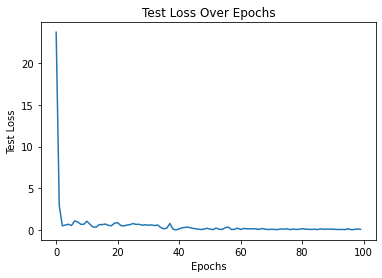

In [11]:
# Run the main function
if __name__ == "__main__":

    #print('OPTIONS ', options)
    # Tuning Parameters:
    import easydict
    from argparse import ArgumentParser
    parser = ArgumentParser()
    args = parser.parse_known_args()[0]
    #使用 easydict，可以创建一个命名空间对象，该对象具有字典的功能，并允许通过点号操作符来访问和设置键值对。
    args = easydict.EasyDict({
            "num_epochs": 100,
            "batch_size": 1,
            "lr": 0.0005,
            "tb_dir": "./runs",
            "final": False,
            "max_pool": False,
            "embedding_size" : 1024,
            "vocab_size" : 50000,
            "max_length" : 520,
            "num_heads" : 2,
            "depth" : 1,
            "seed" : 1,
            "lr_warmup" : 500,
            "gradient_clipping" : 1.0
    })
    evaluation = go(args)

    epoch_numbers = evaluation['epoch']
    test_accuracies = evaluation['Test Accuracy']

    # 将数据转换为 NumPy 数组
    epoch_numbers = np.array(epoch_numbers)
    test_accuracies = np.array(test_accuracies)

    # 获取排序后的索引
    sorted_indices = np.argsort(epoch_numbers)

    # 根据排序后的索引获取排序后的数据
    sorted_epoch_numbers = epoch_numbers[sorted_indices]
    sorted_test_accuracies = test_accuracies[sorted_indices]

    # 绘制迭代MSE折线图
    plt.plot(sorted_epoch_numbers, sorted_test_accuracies)
    plt.xlabel('Epochs')
    plt.ylabel('Test Loss')  # 或者 'Test Accuracy'，具体根据你的情况来确定
    plt.title('Test Loss Over Epochs')
    plt.show()